# Statistical significance & compare magnitude of variation

Note: This notebook requires you to have run collect-and-plot-granular-performance-metrics-ML.ipynb first.  
In this notebook we will compute statistical significance of the granular performance results by testing whether, for each coarse group, there is at least one granular group within that coarse group with significantly different performance. (This is Table 2 from our paper.)  
We will also compare the amount of coarse performance variation to the average amount of granular performance variation for each metric/outcome. (Figure 2 from our paper.)

In [17]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Add preprocessing & analysis folder to path, to import necessary Python helpers
# Please edit the paths to match your local file structure
import sys
sys.path.insert(0, '/home/rm868/granular-race-disparities_MLHC23/preprocessing')
sys.path.insert(0, '/home/rm868/granular-race-disparities_MLHC23/analysis')
from race_categories import *
from utils_plotting_metrics import outcomes_to_labels, metrics_to_labels

from paths import results_path
import os

## Replicate Table 2: statistical significance of granular differences.

Check if performance for a granular group is significantly different from the performance of its broader coarse group.  
We do this by taking the distribution of performance metrics over the N_trials train/test bootstraps, and check if the distribution of differences of granular - coarse metrics is significantly different from zero.

In [ ]:

def get_pvalue_for_diff(arr1, arr2):
    arr1 = arr1.copy()
    arr2 = arr2.copy()
    diff = arr1 - arr2

    # This tests if the distribution of differences in performance are significantly different from 0
    p_value = 2 * (1 - norm.cdf(abs(diff.mean() / diff.std())))

    # Return p-value of z-score
    return p_value

def get_sig_stars(p, MH_factor):
    corrected_p = p * MH_factor
    if corrected_p < 0.001:
        return '***'
    elif corrected_p < 0.01:
        return '**'
    elif corrected_p < 0.05:
        return '*'
    return ''

In [10]:
N_trials = 50
date = '20230823'

coarse_df = pd.DataFrame(pd.read_pickle(os.path.join(results_path, f'logisticregression_coarse_metrics_{N_trials}_{date}.pkl')))
granular_df = pd.DataFrame(pd.read_pickle(os.path.join(results_path, f'logisticregression_granular_metrics_{N_trials}_{date}.pkl')))

In [16]:
# Calibration can also be added as a metric for this analysis by adding 'ece' to the below list
# In the paper, we analyze AUROC, AUPRC, FPR, and FNR for our core analysis
metrics = ['auroc', 'auprc', 'fpr', 'fnr']
outcomes = ['hospitalization', 'critical', 'ed_revisit_3d']
granular_groups = granular_to_coarse.keys()

p_value_df = []
for outcome in outcomes:
    for metric in metrics:
        for granular in granular_groups:
            granular_key = '%s_outcome_%s_%s' % (granular, outcome, metric)
            coarse_key = '%s_outcome_%s_%s' % (granular_to_coarse[granular], outcome, metric)
            p = get_pvalue_for_diff(coarse_df[coarse_key], granular_df[granular_key])
            p_value_df.append({'granular_race': granular, 
                               'coarse_race': granular_to_coarse[granular], 
                               'metric': metric, 
                               'outcome': outcome, 
                               'p': p})

p_value_df = pd.DataFrame(p_value_df)

# We use a conservative multiple-testing correction, the Bonferroni correction.
# All p-values are multiplied up by the total number of comparisons performed, before deciding significance.
MH_factor = len(p_value_df) 
print(f"Number of comparisons (for multiple-testing correction): {MH_factor}")
by_coarse_group = p_value_df.groupby(['metric','outcome', 'coarse_race'])['p'].min().reset_index()
by_coarse_group['sig'] = by_coarse_group['p'].map(lambda x: get_sig_stars(x, MH_factor))
print("Fraction of rows in coarse table with significant p-values at this threshold: %2.3f" % (by_coarse_group['sig'] != '').mean())
display(by_coarse_group)

Number of comparisons (for multiple-testing correction): 312
Fraction of rows in coarse table with significant p-values at this threshold: 0.708


,metric,outcome,coarse_race,p,sig
0,auprc,critical,ASIAN,1.374529e-03,
1,auprc,critical,BLACK/AFRICAN AMERICAN,1.511519e-01,
2,auprc,critical,HISPANIC OR LATINO,6.395292e-05,*
3,auprc,critical,WHITE,2.500276e-06,***
4,auprc,ed_revisit_3d,ASIAN,6.718806e-03,
5,auprc,ed_revisit_3d,BLACK/AFRICAN AMERICAN,2.470839e-09,***
6,auprc,ed_revisit_3d,HISPANIC OR LATINO,1.409204e-10,***
7,auprc,ed_revisit_3d,WHITE,2.220446e-16,***
8,auprc,hospitalization,ASIAN,2.562905e-11,***
9,auprc,hospitalization,BLACK/AFRICAN AMERICAN,2.087013e-01,


## Replicate Figure 2: Comparing magnitudes of within-coarse-group vs. between-coarse-group variation.

The details of this analysis are described in the paper.  

Roughly, *between-coarse-group variation* is defined as the standard deviation in e.g. AUROC across the 4 coarse groups. This standard deviation is averaged across the N_trials train/test bootstraps:

$$\frac{1}{N_t} \sum_{i=1}^{N_t} \text{std}\left(\left\{\text{AUROC}_j\right\}_{j=1}^{N_{\text{coarse}}}\right).$$

*Within-coarse-group variation* is defined as the standard deviation in AUROC across all the granular groups within each coarse groups, averaged across coarse groups. This is also averaged across the N_trials:

$$\frac{1}{N_t} \sum_{i=1}^{N_t} \left(\frac{1}{N_{\text{coarse}}} \sum_{j=1}^{N_{\text{coarse}}} \text{std}\left(\left\{\text{AUROC}_k\right\}_{k=1}^{N_{\text{granular,}j}}\right)\right),$$
 where $N_{\text{granular,}j}$ is the number of granular groups in coarse group $j$.

In [18]:
N_trials = 50
date = '20230823'

coarse_df = pd.DataFrame(pd.read_pickle(os.path.join(results_path, f'logisticregression_coarse_metrics_{N_trials}_{date}.pkl')))
granular_df = pd.DataFrame(pd.read_pickle(os.path.join(results_path, f'logisticregression_granular_metrics_{N_trials}_{date}.pkl')))

In [25]:
metrics = ['auprc', 'auroc', 'fpr', 'fnr']
outcomes = ['hospitalization', 'critical', 'ed_revisit_3d']
granular_groups = granular_to_coarse.keys()
std_df = []

# produce a table of standard deviations across shuffles for each coarse group.
for metric in metrics:
    for outcome in outcomes:
        coarse_metric_vals = [] # will be N_coarse_groups x N_trials; tracks performance for each coarse group. 
        # granular_metric_vals = [] # will be N_granular_groups x N_trials; tracks performance for each granular group.
        granular_stds = [] # will be N_coarse_groups x N_trials; tracks std across granular groups for each coarse group.
        for coarse_group in coarse_races:
            coarse_key = '%s_outcome_%s_%s' % (coarse_group, outcome, metric)
            coarse_metric_vals.append(np.array(coarse_df[coarse_key]))

            # Get all the granular metrics in this coarse group to compute std
            granular_metrics_in_coarse_group = []
            for granular_group in coarse_to_granular[coarse_group]:
                granular_key = '%s_outcome_%s_%s' % (granular_group, outcome, metric)
                granular_metrics_in_coarse_group.append(np.array(granular_df[granular_key]))
            granular_metrics_in_coarse_group = np.array(granular_metrics_in_coarse_group)
            assert granular_metrics_in_coarse_group.shape == (len(coarse_to_granular[coarse_group]), N_trials)
            granular_stds.append(granular_metrics_in_coarse_group.std(axis=0))

        granular_stds = np.array(granular_stds)
        # print("Granular stds shape", granular_stds.shape)

        # Get mean granular std across coarse groups ("within-coarse-variation")
        mean_granular_stds = granular_stds.mean(axis=0)
        # print(mean_granular_stds.shape)
        
        # Get stds across coarse groups ("between-coarse-variation")
        coarse_metric_vals = np.array(coarse_metric_vals)
        # print("Coarse metrics shape:", coarse_metric_vals.shape)
        coarse_stds = coarse_metric_vals.std(axis=0)

        results_for_metric_and_outcome = {
                       'metric': metric, 
                       'outcome': outcome, 
                       'mean_across_coarse_std': coarse_stds.mean(), 
                       'mean_within_coarse_std': mean_granular_stds.mean(),
                       'lower_across_coarse_CI': np.percentile(coarse_stds, 2.5),
                       'upper_across_coarse_CI': np.percentile(coarse_stds, 97.5), 
                       'lower_within_coarse_CI': np.percentile(mean_granular_stds, 2.5),
                       'upper_within_coarse_CI': np.percentile(mean_granular_stds, 97.5), 
                    }

        # Get the amount of granular variation in each coarse group
        for i, coarse_group in enumerate(coarse_races):
            results_for_metric_and_outcome['within_%s_mean_std' % coarse_group] = granular_stds[i, :].mean()
            results_for_metric_and_outcome['within_%s_lower_CI' % coarse_group] = np.percentile(granular_stds[i, :], 2.5)
            results_for_metric_and_outcome['within_%s_upper_CI' % coarse_group] = np.percentile(granular_stds[i, :], 97.5)
        
        std_df.append(results_for_metric_and_outcome)

std_df = pd.DataFrame(std_df)

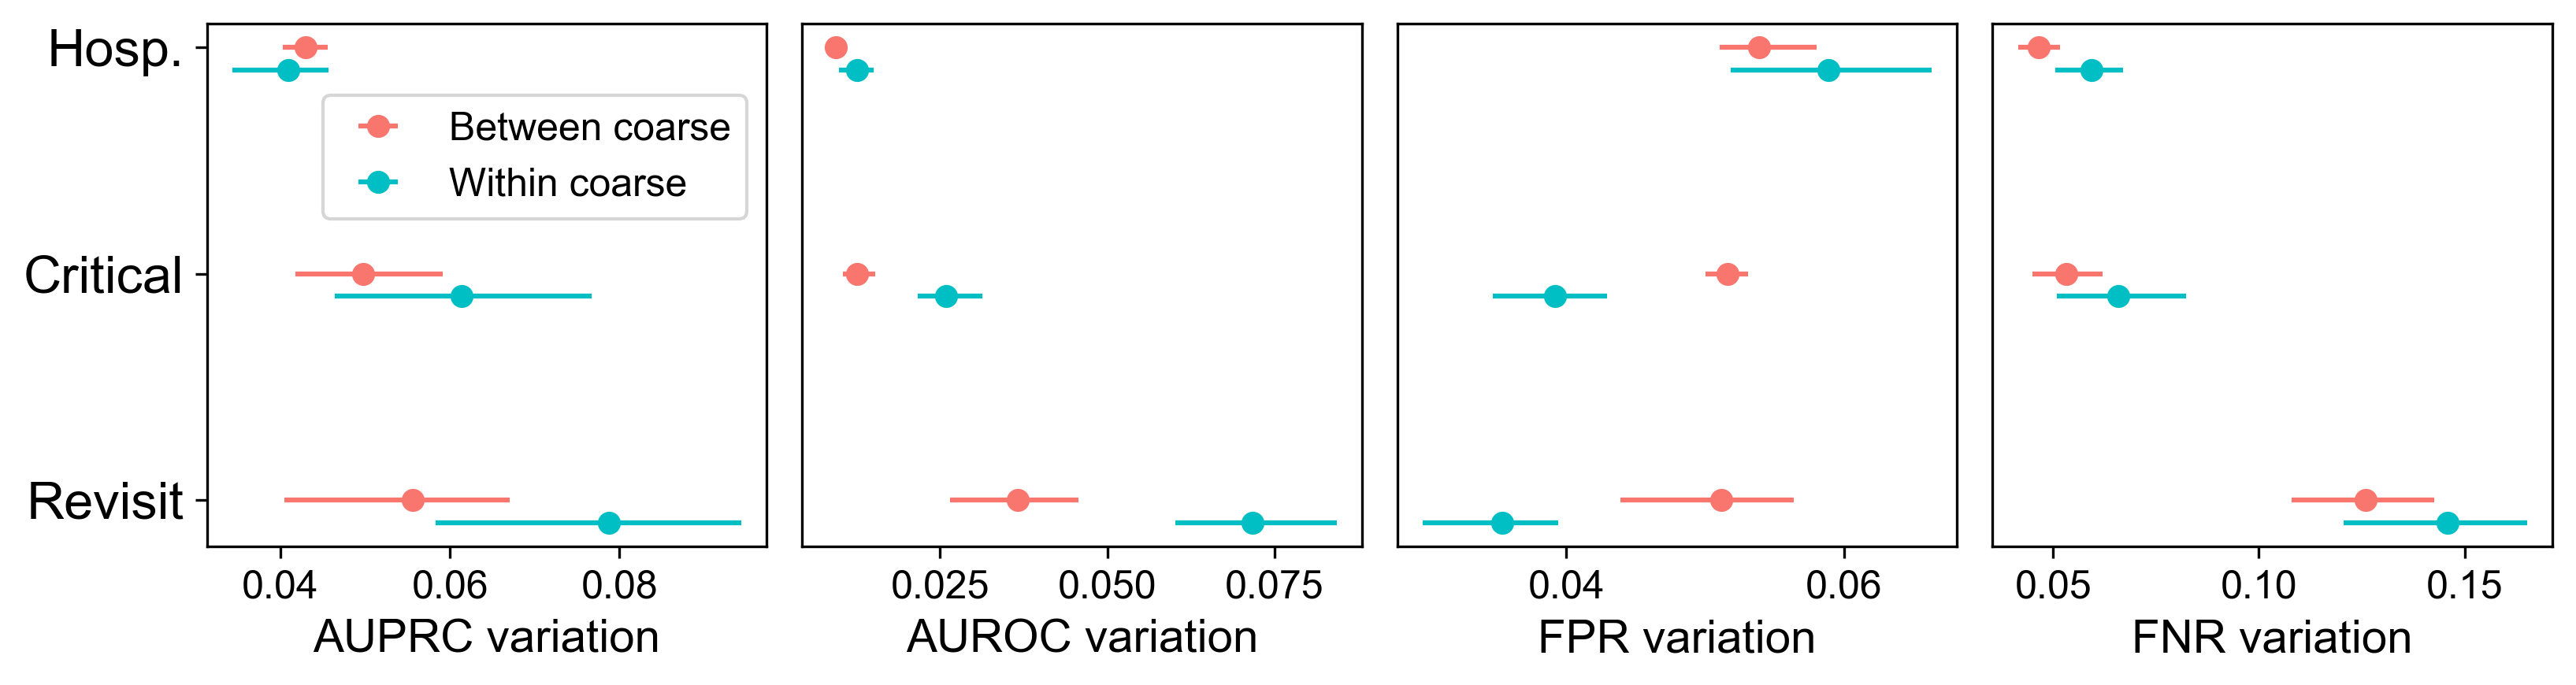

In [27]:
color1 = '#F8766D'
color2 = '#00BFC4'

outcome_labels = ['Revisit', 'Critical', 'Hosp.'][::-1]
metrics_to_labels_short = {
    'auprc': 'AUPRC',
    'auroc': 'AUROC',
    'fpr_fixed': 'FPR',
    'fnr_fixed': 'FNR',
    'fpr': 'FPR',
    'fnr': 'FNR',
}

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(11, 3), dpi=300)
ax = ax.flatten()
for j, metric in enumerate(metrics): # each metric is one subplot. 
    sub_std_df = std_df.loc[std_df['metric'] == metric].copy().reset_index()
    y_sep = 0.1
    y = np.array(range(len(sub_std_df['outcome'])))
    ax[j].errorbar(x=sub_std_df['mean_across_coarse_std'], 
                   y=y, 
                   xerr=np.array([sub_std_df['mean_across_coarse_std'] - sub_std_df['lower_across_coarse_CI'],
                                  sub_std_df['upper_across_coarse_CI'] - sub_std_df['mean_across_coarse_std']]),
                    fmt='o', color=color1, label='Between coarse')
    ax[j].errorbar(x=sub_std_df['mean_within_coarse_std'],
                     y=y + y_sep,
                     xerr=np.array([sub_std_df['mean_within_coarse_std'] - sub_std_df['lower_within_coarse_CI'],
                                      sub_std_df['upper_within_coarse_CI'] - sub_std_df['mean_within_coarse_std']]),
                        fmt='o', color=color2, label='Within coarse')
    ax[j].set_xlabel(f'{metrics_to_labels_short[metric]} variation', fontsize=14)
    ax[j].tick_params(axis='x', which='major', labelsize=12)
    if j == 0:
        ax[j].set_yticks(y, outcome_labels,
                         fontsize=16
                        )
    else:
        ax[j].set_yticks([])

    # Reverse plot y-axis, i.e. plot from top to bottom
    ax[j].invert_yaxis()
        
ax[0].legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.0, 0.9))
fig.tight_layout()
plt.show()